# AutoMl Using H2O

In [10]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

## Load feature engineered CSV

In [11]:
df = pd.read_csv('/Users/prashantkulkarni/Documents/ml-ops/Assignment-3/athletes_cleaned_feature_engg.csv')

In [12]:
df.head(5)

,id,region,gender,age,howlong,backsq_level,deadlift_level,candj_level,snatch_level,strength_score,overall_strength_level,timestamp,total_lift
0,21,Southern California,Male,30.0,1-2 years|,Advanced,Advanced,Advanced,Advanced,3.00,Advanced,2024-11-04 20:46:21.199858,1110.0
1,22,Africa,Male,28.0,2-4 years|,Intermediate,Intermediate,Intermediate,Intermediate,2.00,Intermediate,2024-11-04 20:46:21.199858,910.0
2,27,North East,Male,35.0,2-4 years|,Elite,Advanced,Elite,Elite,3.75,Elite,2024-11-04 20:46:21.199858,1335.0
3,50,North Central,Male,36.0,1-2 years|,Advanced,Elite,Elite,Elite,3.75,Elite,2024-11-04 20:46:21.199858,1354.0
4,60,North East,Male,36.0,4+ years|,Advanced,Advanced,Advanced,Advanced,3.00,Advanced,2024-11-04 20:46:21.199858,1225.0


In [13]:
# Drop the specified columns
df_cleaned = df.drop(columns=['id', 'region', 'timestamp', 'howlong'])

## Initiatize H2O Server

In [24]:
server_address = "35.184.233.137"
h2o.connect(ip=server_address, port=54321)

Connecting to H2O server at http://35.184.233.137:54321 ... successful.


H2O_cluster_uptime:,17 mins 42 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,admin
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.876 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


<H2OConnection to http://35.184.233.137:54321, no session>

## Convert Pandaas DF to H2O DF

In [15]:
# Convert to H2O frame
hf = h2o.H2OFrame(df_cleaned)

# Split the data
train, valid, test = hf.split_frame([0.7, 0.15], seed=1234)



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Identify target and predicting columns

In [16]:
# Identify predictors and response
y = 'total_lift'
x = [col for col in hf.columns if col != y]


## Train Run 1 - Few models first

In [17]:
# Initialize and train AutoML
aml = H2OAutoML(
    max_models=5,           # Maximum number of models to train
    seed=1234,              # For reproducibility
    max_runtime_secs=600,   # Maximum time in seconds
    sort_metric='rmse',  # Metric to optimize
    verbosity='info'        # Level of output detail
)

# Train AutoML
aml.train(x=x, y=y, 
          training_frame=train,
          validation_frame=valid)

# Get the best model
best_model = aml.leader

# Model performance evaluation
performance = best_model.model_performance(test)
print("\nTest Set Performance:")
print(performance)

# Get the leaderboard
lb = aml.leaderboard
print("\nModel Leaderboard:")
print(lb.head())

# Make predictions
predictions = best_model.predict(test)

# Save the model
model_path = h2o.save_model(model=best_model, path="./", force=True)
print(f"\nModel saved to: {model_path}")

# Code for cloud storage upload

# Example of loading the model later
loaded_model = h2o.load_model(model_path)

AutoML progress: |
19:04:50.613: Project: AutoML_1_20241206_190450
19:04:50.616: 5-fold cross-validation will be used.
19:04:50.616: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:04:50.617: Setting stopping tolerance adaptively based on the training frame: 0.006879883494287424
19:04:50.617: Build control seed: 1234
19:04:50.618: training frame: Frame key: AutoML_1_20241206_190450_training_py_9_sid_b71f    cols: 9    rows: 21127  chunks: 1    size: 218795  checksum: -1974911056902571306
19:04:50.618: validation frame: Frame key: py_10_sid_b71f    cols: 9    rows: 4404  chunks: 1    size: 49475  checksum: 38257467017593586
19:04:50.618: leaderboard frame: NULL
19:04:50.619: blending frame: NULL
19:04:50.619: response column: total_lift
19:04:50.619: fold column: null
19:04:50.

In [23]:
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_1_20241206_190450


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  2/4
# GBM base models (used / total)      1/1
# XGBoost base models (used / total)  0/1
# DRF base models (used / total)      1/1
# GLM base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2919.2292758697677
RMSE: 54.02989242881914
MAE: 39.66893537202491
RMSLE: 0.1060488973257162
Mean Residual Deviance: 2919.2292758697677
R^2: 0.9616522192674618
Null degrees of freedom: 10028
Resid

In [26]:
import h2o
from h2o.estimators import H2OXGBoostEstimator

# Print version details
#print(h2o.cluster().build_info)

# Check if XGBoost is available and its version
if H2OXGBoostEstimator.available():
    print("H2O's XGBoost is available.")
else:
    print("H2O's XGBoost is not available.")

H2O's XGBoost is available.


## Evaluate the best model

In [10]:
# Get the best model
best_model = aml.leader

# Variable importance
print("\nVariable Importance:")
print(best_model.varimp())

# Get predictions
predictions = best_model.predict(test)
print("\nPrediction Preview:")
print(predictions.head())

# Detailed performance metrics
print("\nDetailed Performance:")
print(best_model.model_performance(test))


Variable Importance:
None
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

Prediction Preview:
  predict
  1343.23
  1144.97
  1261.39
  1206.33
  1143.32
  1265.97
  1323.31
  1087.78
  1346.84
  1204.18
[10 rows x 1 column]


Detailed Performance:
ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 3165.5102493954787
RMSE: 56.26286741177949
MAE: 41.24602612408349
RMSLE: 0.0952357805075725
Mean Residual Deviance: 3165.5102493954787
R^2: 0.9601301806157303
Null degrees of freedom: 4497
Residual degrees of freedom: 4494
Null deviance: 357124041.85609573
Residual deviance: 14238465.101780863
AIC: 49028.96382583724


## Train Run 2 - Increase the number of models

In [10]:
# Improving the model
aml = H2OAutoML(
    max_models=20,           # Increase number of models
    max_runtime_secs=600,    # Give it more time
    seed=1,                  # For reproducibility
    sort_metric="rmse",      # Explicitly optimize for RMSE
    exclude_algos=['GLM']    # exclude poorly performing algorithms
)

In [11]:
# Train AutoML
aml.train(x=x, y=y, 
          training_frame=train,
          validation_frame=valid)

# Get the best model
best_model = aml.leader

# Model performance evaluation
performance = best_model.model_performance(test)
print("\nTest Set Performance:")
print(performance)

# Get the leaderboard
lb = aml.leaderboard
print("\nModel Leaderboard:")
print(lb.head())

# Make predictions
predictions = best_model.predict(test)

# Save the model
model_path = h2o.save_model(model=best_model, path="./", force=True)
print(f"\nModel saved to: {model_path}")

# Example of loading the model later
loaded_model = h2o.load_model(model_path)

AutoML progress: |
13:15:47.689: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
13:15:47.690: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Test Set Performance:
ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 3141.0672683805956
RMSE: 56.04522520590488
MAE: 41.13910885781035
RMSLE: 0.09489890478994263
Mean Residual Deviance: 3141.0672683805956
R^2: 0.9604380416433363
Null degrees of freedom: 4497
Residual degrees of freedom: 4493
Null deviance: 357124041.85609573
Residual deviance: 14128520.573175918
AIC: 48996.0970288082

Model Leaderboard:
model_id                                                    rmse      mse      mae      rmsle    mean_residual_deviance
StackedEnse

## Evaluate Run 2

In [12]:
# Get the best model
best_model = aml.leader

# Variable importance
print("\nVariable Importance:")
print(best_model.varimp())

# Get predictions
predictions = best_model.predict(test)
print("\nPrediction Preview:")
print(predictions.head())

# Detailed performance metrics
print("\nDetailed Performance:")
print(best_model.model_performance(test))


Variable Importance:
None
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

Prediction Preview:
  predict
  1344.08
  1143.36
  1259.12
  1205.62
  1143.06
  1261.49
  1325.01
  1090.25
  1347.86
  1204.78
[10 rows x 1 column]


Detailed Performance:
ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 3141.0672683805956
RMSE: 56.04522520590488
MAE: 41.13910885781035
RMSLE: 0.09489890478994263
Mean Residual Deviance: 3141.0672683805956
R^2: 0.9604380416433363
Null degrees of freedom: 4497
Residual degrees of freedom: 4493
Null deviance: 357124041.85609573
Residual deviance: 14128520.573175918
AIC: 48996.0970288082


# What are the reported top 5 features?


Stacked ensemble model doesn't show variable but we will find it for GBM models


Using model: GBM_grid_1_AutoML_3_20241116_131547_model_3

Variable Importance from GBM:
                 variable  relative_importance  scaled_importance  percentage
0  overall_strength_level         2.144377e+09           1.000000    0.308988
1            backsq_level         1.376511e+09           0.641916    0.198344
2          strength_score         1.112510e+09           0.518803    0.160304
3          deadlift_level         1.002526e+09           0.467514    0.144456
4             candj_level         9.570220e+08           0.446294    0.137899
5            snatch_level         2.630932e+08           0.122690    0.037910
6                  gender         7.787946e+07           0.036318    0.011222
7                     age         6.089222e+06           0.002840    0.000877


/Users/prashantkulkarni/Library/jupyterlab-desktop/envs/local-jupyterlab/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


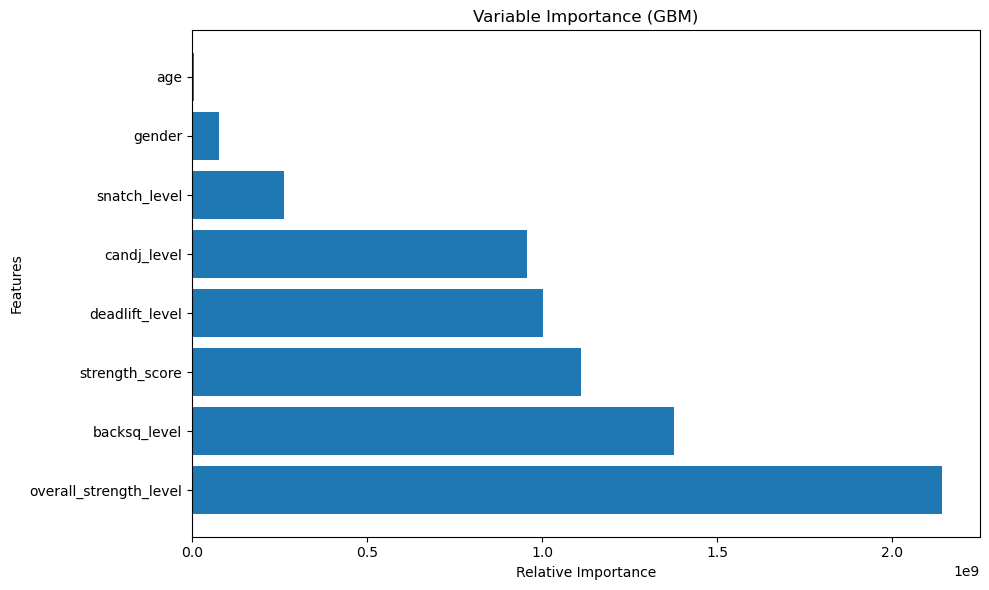

In [16]:
import matplotlib as plt

# Get the first GBM model
gbm_models = [m for m in aml.leaderboard['model_id'].as_data_frame()['model_id'] if 'GBM' in m]
if gbm_models:
    gbm_model = gbm_models[0]
    print(f"\nUsing model: {gbm_model}")
    gbm = h2o.get_model(gbm_model)
    print("\nVariable Importance from GBM:")
    print(gbm.varimp(use_pandas=True))
else:
    print("No GBM models found in the leaderboard")

# You can also visualize it
import pandas as pd
import matplotlib.pyplot as plt

# Get variable importance as pandas DataFrame
varimp_df = gbm.varimp(use_pandas=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(varimp_df['variable'], varimp_df['relative_importance'])
plt.title('Variable Importance (GBM)')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## What are the top 3 models per validation score when using
### all features
### only the top features (if you have to choose a number put in 3)


In [17]:
# Get the GBM model
gbm_model = h2o.get_model("GBM_grid_1_AutoML_3_20241116_131547_model_3")
varimp = gbm_model.varimp(use_pandas=True)
print("\nTop 3 Features:")
print(varimp.head(3))

# Now run AutoML with only top 3 features
top_features = list(varimp['variable'][:3])
aml_top_features = H2OAutoML(
    max_models=10,
    seed=1,
    max_runtime_secs=300
)

# Train with only top features
aml_top_features.train(x=top_features, y=y, training_frame=train)

print("\nLeaderboard with Top Features Only:")
print(aml_top_features.leaderboard)


Top 3 Features:
                 variable  relative_importance  scaled_importance  percentage
0  overall_strength_level         2.144377e+09           1.000000    0.308988
1            backsq_level         1.376511e+09           0.641916    0.198344
2          strength_score         1.112510e+09           0.518803    0.160304
AutoML progress: |
13:30:42.590: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Leaderboard with Top Features Only:
model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
GBM_1_AutoML_4_20241116_133042                           57.3693  3291.24  42.7238  0.101639                   3291.24
StackedEnsemble_AllModels_1_AutoML_4_20241116_133042     57.3841  3292.93  42.7464  0.101637                   3292.93
StackedEnsemble_BestOfFamily_1_AutoML_4_20241116_133042  57.3964  3294.34  42.7643  0.101665                   3294.34


## What are the top 3 models per speed when using
### all features
### only the top features (if you have to choose a number put in 3)

## Train with only top 3 features

In [19]:
# Train with only top 3 features
x_top = ['overall_strength_level', 'backsq_level', 'strength_score']

aml_top = H2OAutoML(
    max_models=10,
    seed=1,
    max_runtime_secs=300
)

# Time the training
import time
start_time = time.time()
aml_top.train(x=x_top, y=y, training_frame=train)
top_features_time = time.time() - start_time

print("\nLeaderboard with Top 3 Features:")
print(aml_top.leaderboard)
print(f"\nTraining time with top features: {top_features_time:.2f} seconds")

AutoML progress: |
13:32:58.749: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Leaderboard with Top 3 Features:
model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
GBM_1_AutoML_5_20241116_133258                           57.3693  3291.24  42.7238  0.101639                   3291.24
StackedEnsemble_AllModels_1_AutoML_5_20241116_133258     57.3924  3293.89  42.7544  0.101651                   3293.89
StackedEnsemble_BestOfFamily_1_AutoML_5_20241116_133258  57.3959  3294.29  42.7666  0.101641                   3294.29
GBM_3_AutoML_5_20241116_133258                           57.4058  3295.43  42.7552  0.101687                   3295.43
GBM_4_AutoML_5_20241116_133258                           57.4129  3296.25  42.7785  0.101656                   3296.25
GBM_2_AutoML_5_20241116_133258                           57.4275  3297.92  42.7866  0.101715  

## Top 3 Models by Validation Score (RMSE - lower is better):
A. All Features:

* 1st: StackedEnsemble_AllModels (RMSE = 54.87)
* 2nd: StackedEnsemble_BestOfFamily (RMSE = 54.88)
* 3rd: GBM_grid_model_3 (RMSE = 54.89)

B. Top 3 Features Only:

* 1st: GBM_1 (RMSE = 57.37)
* 2nd: StackedEnsemble_AllModels (RMSE = 57.39)
* 3rd: StackedEnsemble_BestOfFamily (RMSE = 57.40)


## Performance Impact:

* Using all features is better (RMSE 54.87 vs 57.37)
* Performance degradation: ~4.6% when using only top 3 features


## Model Training Speed:

* Top 3 features: 8.63 seconds
* Full feature set: Longer 



## Key Insights:

* The reduced feature set trades a 4.6% performance loss for faster training
* Model rankings changed - GBM performs better than ensembles with fewer features
* The spread between best and worst models is larger with fewer features

## Speed

### What are the top 3 models per speed when using
* all features
* only the top features (if you have to choose a number put in 3)

In [22]:
# Train with timing for each model type
import time
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator

# For top 3 features
x_top = ['overall_strength_level', 'backsq_level', 'strength_score']

def time_model_training(model_type, x, y, train_frame):
    start_time = time.time()
    if model_type == "GLM":
        model = H2OGeneralizedLinearEstimator()
    elif model_type == "GBM":
        model = H2OGradientBoostingEstimator()
    elif model_type == "DRF":
        model = H2ORandomForestEstimator()
    
    model.train(x=x, y=y, training_frame=train_frame)
    return time.time() - start_time

# Time each model type with both feature sets
for features in [x_top, x]:
    feature_set = "Top 3" if len(features) == 3 else "All"
    print(f"\nTiming for {feature_set} features:")
    for model in ["GLM", "GBM", "DRF"]:
        train_time = time_model_training(model, features, y, train)
        print(f"{model}: {train_time:.2f} seconds")


Timing for Top 3 features:
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GLM: 0.38 seconds
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM: 0.24 seconds
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF: 0.25 seconds

Timing for All features:
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GLM: 0.23 seconds
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM: 0.23 seconds
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
DRF: 0.44 seconds


# How does the top models compare to your previously developed model (assignments 1 and 2) in terms of validation score and speed?


The R2^2 of the model is pretty similar however you can see AutoML favors ensemble model (which isn't a bad idea)

# Is your platform AutoML no-code/low-code/full-code and why?


This is a low code platform as you can see I had to barely write any code.